<a href="https://colab.research.google.com/github/aaldayarova/glaucoma-detection/blob/main/GlaucomaDetection_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MOUNTING GDRIVE

from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

root_path = '/content/drive/My Drive/Neuro140Project'

Mounted at /content/drive


In [ ]:
# IMPORTING LIBRARIES

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import tensorflow as tf
from tensorflow import keras

from random import randint 
from pathlib import Path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple

from PIL import ImageFile, Image
from torch.utils.data import Dataset 

import pandas as pd
import cv2

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
# ESTABLISHING NECESSARY PATHS

train_path = '/content/drive/My Drive/Neuro140Project/Fundus_Scanes_Sorted/Train'
test_path = '/content/drive/My Drive/Neuro140Project/Fundus_Scanes_Sorted/Test'

csv_path = '/content/drive/My Drive/Neuro140Project/glaucoma_new.csv'

HEIGHT = 2048 
WIDTH = 3072

In [ ]:
# CREATING TEST + TRAIN DATASET ARRAYS

# Creating a train dataset array
train = []

for folder in os.listdir(train_path):
    
    # Touching the 'Glaucoma_Positive' and 'Glaucoma_Negative' folders
    sub_path = train_path + "/" + folder

    for image in os.listdir(sub_path):

        # Touching every image within both folders
        image_path = sub_path + "/" + image

        image_array = cv2.imread(image_path)

        image_array = cv2.resize(image_array,(224,224))

        train.append(image_array)

# Creating a test dataset array
test = []

for folder in os.listdir(test_path):
    
    sub_path = test_path + "/" + folder

    for image in os.listdir(sub_path):

        image_path = sub_path + "/" + image

        image_array = cv2.imread(image_path)

        image_array = cv2.resize(image_array,(224,224))

        test.append(image_array)

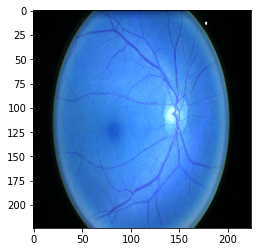

In [ ]:
# Checking images 
#plt.imshow(train[130]/255.0)
plt.imshow(test[99])

In [ ]:
# Wrapping arrays by numpy to allow to normalize later
training_data = np.array(train)
testing_data = np.array(test)

In [ ]:
# Normalizing our arrays
training_data = training_data/255.0
testing_data = testing_data/255.0

In [ ]:
# CREATING LABELS FOR DATA
training_l = ImageDataGenerator(rescale = 1./255.0)
testing_l = ImageDataGenerator(rescale = 1./255.0)    

In [ ]:
# Walking through the folders to generate the labels for each image
train_labels = training_l.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_labels = testing_l.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

# Interpreting the results:
# 520 images are in the 'Train' folder
    # They are divided into 2 classes, 'Glaucoma_Negative' and 'Glaucoma_Positive'
# 130 images are in the 'Test' folder 
    # They are, too, divided into 2 classes, 'Glaucoma_Negative' and 'Glaucoma_Positive'

Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
# Creating clear variables to store the 'classes' or the 'labels' of those walks
training_labels = train_labels.classes
testing_labels = test_labels.classes

# Interpreting classes for analysis later on:
# There are two classes, 'Glaucoma_Negative' and 'Glaucoma_Positive', each stored under one index.
    # 'Glaucoma_Negative' is stored under index 0; 'Glaucoma_Positive' is stored under index 1

Below, all blocks of code pertain to training given models. Uncommented blocks of code represent the current model being trained and analyzed.

In [ ]:
# TRAINING MODEL #1 -- VGG19 

model_vgg = VGG19(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# Making sure we don't train the pre-trained layers
for l in model_vgg.layers:
    l.trainable = False

In [ ]:
# Flattening the last layer of the CNN in order to accurately classify
last_layer = Flatten()(model_vgg.output)

In [ ]:
# Customizing the last layer to have only 2 classes, '0' and '1'
classification = Dense(2, activation='softmax')(last_layer)

model_1 = Model(inputs = model_vgg.input, outputs = classification)

In [ ]:
# Compiling our first model
opt = keras.optimizers.Adam(learning_rate = 0.01)
model_1.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
# Running (training) our first model and measuring metrics
history_1 = model_1.fit(training_data, training_labels, epochs = 5, batch_size = 32, shuffle = True)

Epoch 1/5
17/17 [==============================] - 20s 390ms/step - loss: 12.5156 - accuracy: 0.6019
Epoch 2/5
17/17 [==============================] - 5s 310ms/step - loss: 2.8243 - accuracy: 0.6635
Epoch 3/5
17/17 [==============================] - 5s 310ms/step - loss: 3.0201 - accuracy: 0.6231
Epoch 4/5
17/17 [==============================] - 5s 311ms/step - loss: 3.1285 - accuracy: 0.6827
Epoch 5/5
17/17 [==============================] - 5s 310ms/step - loss: 2.9168 - accuracy: 0.6750


In [ ]:
# # SAVING MODEL #1 -- VGG19
# torch.save(model_1, root_path + "/first_model.pt")

INFO:tensorflow:Assets written to: ram://c59f3a83-fde5-4bf5-a55f-7a31c77c9ddb/assets


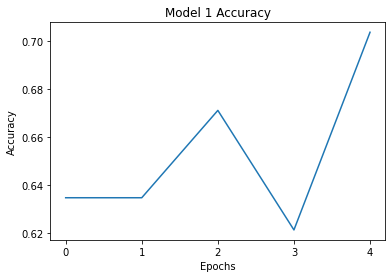

In [ ]:
# # FIGURES FOR MODEL #1 -- VGG19

# fig = plt.figure()

# # add the accuracy data to the plot
# accuracy = history_1.history['accuracy']
# plt.plot(accuracy)

# # arrange the axes and labels 
# plt.title("Model 1 Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.xticks(np.arange(0, 5, 1.0))

# plt.show()

In [ ]:
# # SAVE THE MODEL #1 (VGG19) FIGURES
# fig.savefig('first_model_accuracy.png')

In [ ]:
# TESTING MODEL #1 (VGG19)

model_1.evaluate(testing_data, testing_labels, batch_size = 32)

5/5 [==============================] - 3s 521ms/step - loss: 1.7424 - accuracy: 0.5923


[1.7423932552337646, 0.5923076868057251]

In [ ]:
# TRAINING MODEL #2 -- VGG16

model_vgg2 = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Making sure we don't train the pre-trained layers
for l in model_vgg2.layers:
    l.trainable = False

In [ ]:
# Flattening the last layer of the CNN in order to accurately classify
last_layer2 = Flatten()(model_vgg2.output)

In [ ]:
# Customizing the last layer to have only 2 classes, '0' and '1'
classification2 = Dense(2, activation='softmax')(last_layer2)

model_2 = Model(inputs = model_vgg2.input, outputs = classification2)

In [ ]:
# Compiling our second model
opt = keras.optimizers.Adam(learning_rate = 0.01)
model_2.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
# Running (training) our second model and measuring metrics
history_2 = model_2.fit(training_data, training_labels, epochs = 5, batch_size = 32, shuffle = True)

Epoch 1/5
17/17 [==============================] - 5s 269ms/step - loss: 9.6815 - accuracy: 0.5808
Epoch 2/5
17/17 [==============================] - 4s 265ms/step - loss: 4.2354 - accuracy: 0.6519
Epoch 3/5
17/17 [==============================] - 4s 264ms/step - loss: 1.0412 - accuracy: 0.7250
Epoch 4/5
17/17 [==============================] - 5s 265ms/step - loss: 0.6559 - accuracy: 0.7558
Epoch 5/5
17/17 [==============================] - 5s 265ms/step - loss: 0.3688 - accuracy: 0.8327


In [ ]:
# SAVING MODEL #2 -- VGG16
torch.save(model_2, root_path + "/second_model.pt")

INFO:tensorflow:Assets written to: ram://8a3fd673-9da9-40de-87bb-4f8495e4525c/assets


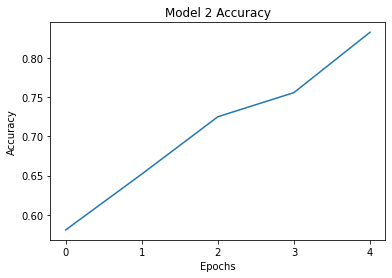

In [ ]:
# FIGURES FOR MODEL #2 -- VGG16

fig = plt.figure()

# add the accuracy data to the plot
accuracy = history_2.history['accuracy']
plt.plot(accuracy)

# arrange the axes and labels 
plt.title("Model 2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 5, 1.0))

plt.show()

In [ ]:
# SAVE THE MODEL #2 (VGG16) FIGURES
fig.savefig('second_model_accuracy.png')

In [ ]:
# TESTING MODEL #2 (VGG16)

model_2.evaluate(testing_data, testing_labels, batch_size = 32)

5/5 [==============================] - 2s 233ms/step - loss: 0.9200 - accuracy: 0.7077


[0.9199853539466858, 0.7076923251152039]

In [ ]:
# TRAINING MODEL #3 -- MobileNetV2

model_mb = tf.keras.applications.MobileNetV2(include_top = False, weights = 'imagenet')

In [ ]:
# Freezing the convolutional layers
model_mb.trainable = False

In [ ]:
# Obtaining the final prediction from the feature extractions
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
classification3 = tf.keras.layers.Dense(2)

In [ ]:
# Putting everything together and compiling the model
model_3 = tf.keras.Sequential([model_mb, global_average_layer, classification3])

model_3.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,), metrics = ['accuracy'])

In [ ]:
# Training the model 
history_3 = model_3.fit(training_data, training_labels, epochs = 5, batch_size = 32, shuffle = True)

Epoch 1/5
17/17 [==============================] - 5s 88ms/step - loss: 3.9752 - accuracy: 0.7096
Epoch 2/5
17/17 [==============================] - 1s 84ms/step - loss: 3.9749 - accuracy: 0.7423
Epoch 3/5
17/17 [==============================] - 1s 83ms/step - loss: 3.9749 - accuracy: 0.7423
Epoch 4/5
17/17 [==============================] - 1s 83ms/step - loss: 3.9749 - accuracy: 0.7423
Epoch 5/5
17/17 [==============================] - 1s 83ms/step - loss: 3.9749 - accuracy: 0.7423


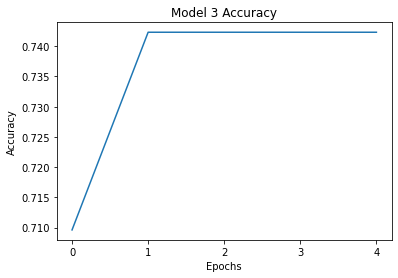

In [ ]:
# FIGURES FOR MODEL #3 -- MobileNetV2

fig = plt.figure()

# add the accuracy data to the plot
accuracy = history_3.history['accuracy']
plt.plot(accuracy)

# arrange the axes and labels 
plt.title("Model 3 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 5, 1.0))

plt.show()

In [ ]:
# SAVING MODEL #3 -- MobileNet
torch.save(model_3, root_path + "/third_model.pt")

INFO:tensorflow:Assets written to: ram://4ae65512-b003-498d-a840-933ce3d24cd5/assets


INFO:tensorflow:Assets written to: ram://4ae65512-b003-498d-a840-933ce3d24cd5/assets


In [ ]:
# TESTING MODEL #3 (MobileNetV2)

model_3.evaluate(testing_data, testing_labels, batch_size = 32)

5/5 [==============================] - 2s 159ms/step - loss: 4.0342 - accuracy: 0.7385


[4.034217357635498, 0.7384615540504456]